In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import gpytorch
import torch
import time
import numpy as np
#%matplotlib inline

#pd.set_option("display.max_rows", None)
#pd.set_option("display.max_columns", None)

In [2]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
from tueplots import bundles
plt.rcParams.update(bundles.neurips2021())
figheight = bundles.neurips2021()["figure.figsize"][1]
figwidth = bundles.neurips2021()["figure.figsize"][0]
print(figheight, figwidth)

1.699593426303529 5.499999861629998


## Load and visualize data

In [4]:
poisson_df = pd.read_csv('data/poisson_sim.csv')
poisson_df

,id,num_awards,prog,math
0,45,0,3,41
1,108,0,1,41
2,15,0,3,44
3,67,0,3,42
4,153,0,3,40
...,...,...,...,...
195,100,2,2,71
196,143,2,3,75
197,68,1,2,71
198,57,0,2,72


In [5]:
poisson_df.drop(columns = ['id'], inplace=True)

poisson_general_df = poisson_df[poisson_df['prog'] == 1]
poisson_academic_df = poisson_df[poisson_df['prog'] == 2]
poisson_vocational_df = poisson_df[poisson_df['prog'] == 3]

<ipython-input-6-976276c5d47f>:15: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


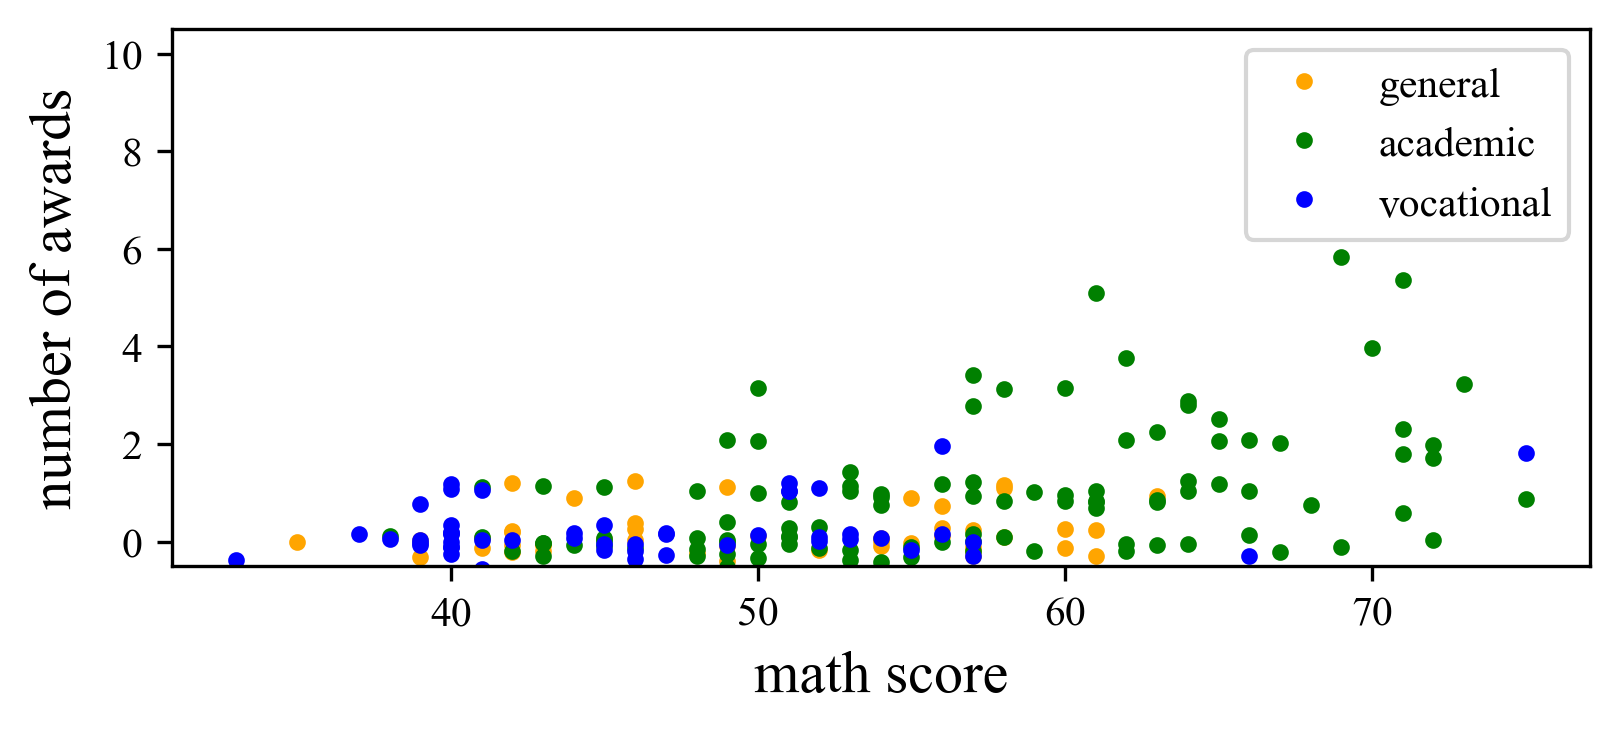

In [6]:
s = 0.2
eps1 = np.random.normal(0, 0.2, size=len(poisson_general_df))
eps2 = np.random.normal(0, 0.2, size=len(poisson_academic_df))
eps3 = np.random.normal(0, 0.2, size=len(poisson_vocational_df))

fig = plt.figure(figsize=(figwidth, 1.5*figheight), dpi=300)
plt.ylim(-0.5, 10.5)
plt.ylabel('number of awards', size=14)
plt.xlabel('math score', size=14)
plt.plot(poisson_general_df['math'], poisson_general_df['num_awards']+eps1, '.', label="general", color='orange')
plt.plot(poisson_academic_df['math'], poisson_academic_df['num_awards']+eps2, '.', label="academic", color='green')
plt.plot(poisson_vocational_df['math'], poisson_vocational_df['num_awards']+eps3, '.', label="vocational", color='blue')
plt.legend()

plt.tight_layout()

plt.savefig('figures/Poisson_all_points.pdf')

plt.show();

In [7]:
from scipy.special import gamma as gamma_func

def gamma_pdf(x, a, b):
    r = b**a/gamma_func(a) * (x ** (a-1)) * (np.exp(-x*b))
    return(r)

In [8]:
poisson_general_df[poisson_general_df['math'] == 57]

,num_awards,prog,math
40,0,1,57
87,0,1,57
99,0,1,57
160,0,1,57


In [9]:
poisson_academic_df[poisson_academic_df['math'] == 57]

,num_awards,prog,math
96,1,2,57
113,0,2,57
133,0,2,57
137,1,2,57
140,0,2,57
149,3,2,57
171,3,2,57


In [10]:
poisson_vocational_df[poisson_vocational_df['math'] == 57]

,num_awards,prog,math
103,0,3,57
115,0,3,57


## Looking at one of the marginal Gamma distributions

<ipython-input-7-2a58befc71af>:4: RuntimeWarning: divide by zero encountered in power
  r = b**a/gamma_func(a) * (x ** (a-1)) * (np.exp(-x*b))


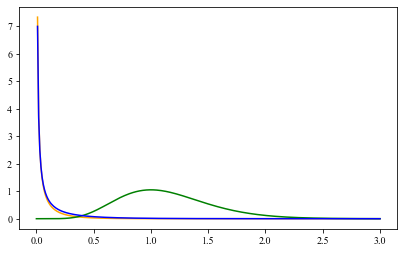

In [11]:
x = np.linspace(0, 3, 300+1)
alpha_0 = 0.1
beta_0 = 0.1

gamma_test = gamma_pdf(x, alpha_0+1, beta_0+1)

gamma_general = gamma_pdf(x, alpha_0+0, beta_0+4)
gamma_academic = gamma_pdf(x, alpha_0+8, beta_0+7)
gamma_vocational = gamma_pdf(x, alpha_0+0, beta_0+2)

plt.figure(figsize=(figwidth, 2*figheight))

plt.plot(x, gamma_general, color='orange')
plt.plot(x, gamma_academic, color='green')
plt.plot(x, gamma_vocational, color='blue')
plt.show();

In [12]:
def get_counts_and_num_awards(df):
    
    df_new = df.groupby(['math']).size().reset_index(name='counts')
    df_new['sum_awards'] = df.groupby(['math']).sum().reset_index()['num_awards']
    
    return(df_new)

In [13]:
poisson_general_combined_df = get_counts_and_num_awards(poisson_general_df)
poisson_academic_combined_df = get_counts_and_num_awards(poisson_academic_df)
poisson_vocational_combined_df = get_counts_and_num_awards(poisson_vocational_df)

In [14]:
def add_alpha_beta(df, alpha_0=0.1, beta_0=0.1):
    
    df['alpha'] = df['sum_awards'] + alpha_0
    df['beta'] = df['counts'] + beta_0
    return(df)

In [15]:
poisson_general_combined_df = add_alpha_beta(poisson_general_combined_df)
poisson_academic_combined_df = add_alpha_beta(poisson_academic_combined_df)
poisson_vocational_combined_df = add_alpha_beta(poisson_vocational_combined_df)

In [16]:
def add_mu_sigma(df):
    
    df['mu'] = np.log(df['alpha'] / df['beta'])
    df['sigma2'] = 1 / df['alpha']
    return(df)

In [17]:
poisson_general_combined_df = add_mu_sigma(poisson_general_combined_df)
poisson_academic_combined_df = add_mu_sigma(poisson_academic_combined_df)
poisson_vocational_combined_df = add_mu_sigma(poisson_vocational_combined_df)

# Use GP+LM
using prepackages GPs from SciKit learn

In [18]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel() + gpytorch.kernels.LinearKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### For the general group

In [19]:
poisson_general_scatter_df = poisson_general_df.groupby(['math', 'num_awards']).size().reset_index(name="count")
poisson_general_scatter_df.head(5)

,math,num_awards,count
0,35,0,1
1,39,0,2
2,41,0,2
3,42,0,4
4,42,1,1


In [20]:
X_general = torch.tensor(poisson_general_combined_df['math'])
Y_general = torch.tensor(poisson_general_combined_df['mu']).float()

x_general = torch.tensor(np.array(range(X_general.min() - 10, X_general.max() + 10)))

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_covar=torch.tensor(np.sqrt(poisson_general_combined_df['sigma2'].values)))
model = ExactGPModel(X_general.view(-1,1), Y_general, likelihood)

In [21]:
# this is for running the notebook in our testing framework
training_iter = 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_general.view(-1,1))
    # Calc loss and backprop gradients
    loss = -mll(output, Y_general)
    loss.backward()
    #print(model.covar_module.base_kernel.kernels[0])
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.kernels[0].lengthscale.item(),
            model.likelihood.noise.item()
        ))
    optimizer.step()

Iter 1/50 - Loss: 1.991   lengthscale: 0.693   noise: 0.693
Iter 6/50 - Loss: 1.893   lengthscale: 0.477   noise: 0.955
Iter 11/50 - Loss: 1.831   lengthscale: 0.330   noise: 1.176
Iter 16/50 - Loss: 1.785   lengthscale: 0.241   noise: 1.289
Iter 21/50 - Loss: 1.747   lengthscale: 0.190   noise: 1.303
Iter 26/50 - Loss: 1.713   lengthscale: 0.162   noise: 1.274
Iter 31/50 - Loss: 1.686   lengthscale: 0.146   noise: 1.261
Iter 36/50 - Loss: 1.665   lengthscale: 0.136   noise: 1.292
Iter 41/50 - Loss: 1.654   lengthscale: 0.130   noise: 1.346
Iter 46/50 - Loss: 1.645   lengthscale: 0.126   noise: 1.385


In [22]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(x_general))

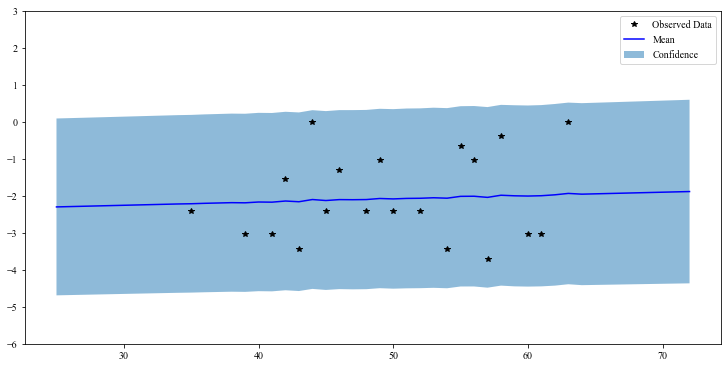

In [23]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 5))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(X_general.numpy(), Y_general.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(x_general.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(x_general.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-6, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    

<ipython-input-24-88dc8f2302df>:18: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


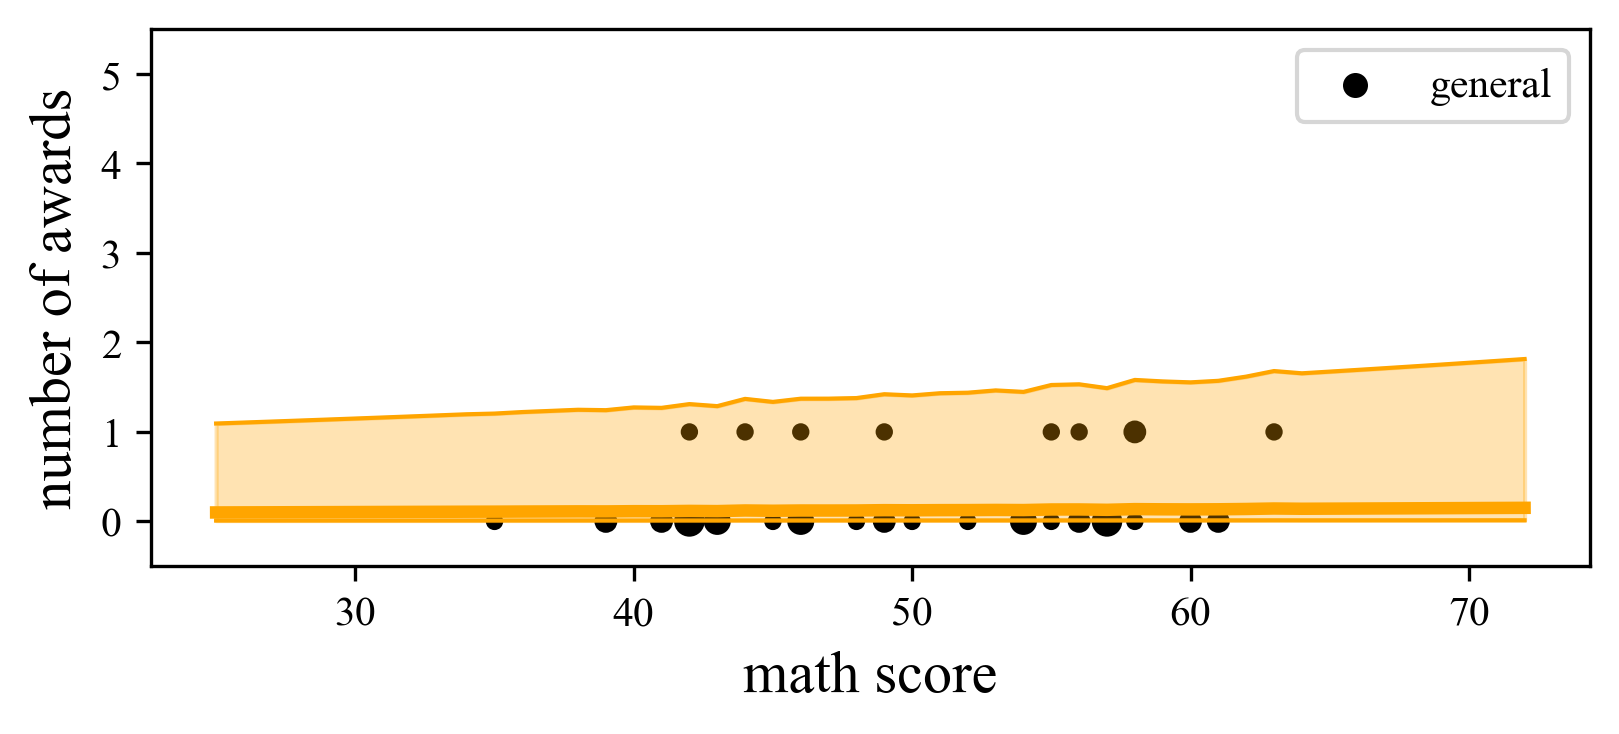

In [24]:
general_mean = np.exp(observed_pred.mean.numpy())
lb_general, ub_general = observed_pred.confidence_region()
lb_general, ub_general = np.exp(lb_general), np.exp(ub_general)

fig = plt.figure(figsize=(figwidth, 1.5*figheight), dpi=300)

plt.ylim(-0.5, 5.5)
plt.ylabel('number of awards', size=14)
plt.xlabel('math score', size=14)
plt.scatter(poisson_general_scatter_df['math'], poisson_general_scatter_df['num_awards'],
            s=10* poisson_general_scatter_df['count'], color='black', label='general')
plt.plot(x_general, general_mean, lw=3, color='orange')
plt.plot(x_general, ub_general, lw=1, color='orange')
plt.plot(x_general, lb_general, lw=1, color='orange')
plt.fill_between(x_general, lb_general, ub_general, alpha=0.3, color='orange')
plt.legend()

plt.tight_layout()

plt.savefig('figures/general_GP.pdf')

plt.plot();

### For academic

In [25]:
poisson_academic_scatter_df = poisson_academic_df.groupby(['math', 'num_awards']).size().reset_index(name="count")
poisson_academic_scatter_df.head(5)

,math,num_awards,count
0,38,0,1
1,41,0,1
2,41,1,1
3,42,0,1
4,43,0,3


In [26]:
X_academic = torch.tensor(poisson_academic_combined_df['math'])
Y_academic = torch.tensor(poisson_academic_combined_df['mu']).float()

x_academic = torch.tensor(np.array(range(X_academic.min() - 10, X_academic.max() + 10)))

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_covar=torch.tensor(np.sqrt(poisson_academic_combined_df['sigma2'].values)))
model = ExactGPModel(X_academic.view(-1,1), Y_academic, likelihood)

# this is for running the notebook in our testing framework
training_iter = 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_academic.view(-1,1).long())
    # Calc loss and backprop gradients
    loss = -mll(output, Y_academic)
    loss.backward()
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.kernels[0].lengthscale.item(),
            model.likelihood.noise.item()
        ))
    optimizer.step()
    
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(x_academic))

Iter 1/50 - Loss: 1.641   lengthscale: 0.693   noise: 0.693
Iter 6/50 - Loss: 1.541   lengthscale: 0.968   noise: 0.476
Iter 11/50 - Loss: 1.501   lengthscale: 1.224   noise: 0.374
Iter 16/50 - Loss: 1.466   lengthscale: 1.356   noise: 0.421
Iter 21/50 - Loss: 1.432   lengthscale: 1.421   noise: 0.521
Iter 26/50 - Loss: 1.406   lengthscale: 1.482   noise: 0.592
Iter 31/50 - Loss: 1.382   lengthscale: 1.548   noise: 0.599
Iter 36/50 - Loss: 1.358   lengthscale: 1.607   noise: 0.581
Iter 41/50 - Loss: 1.340   lengthscale: 1.654   noise: 0.579
Iter 46/50 - Loss: 1.328   lengthscale: 1.687   noise: 0.592


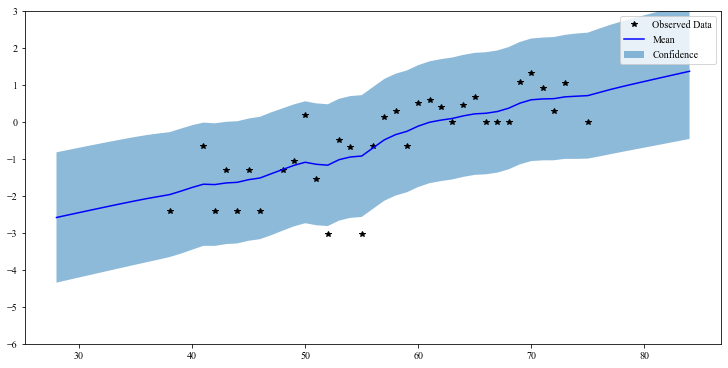

In [27]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 5))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(X_academic.numpy(), Y_academic.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(x_academic.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(x_academic.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-6, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    

<ipython-input-28-9345d24fe40e>:18: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


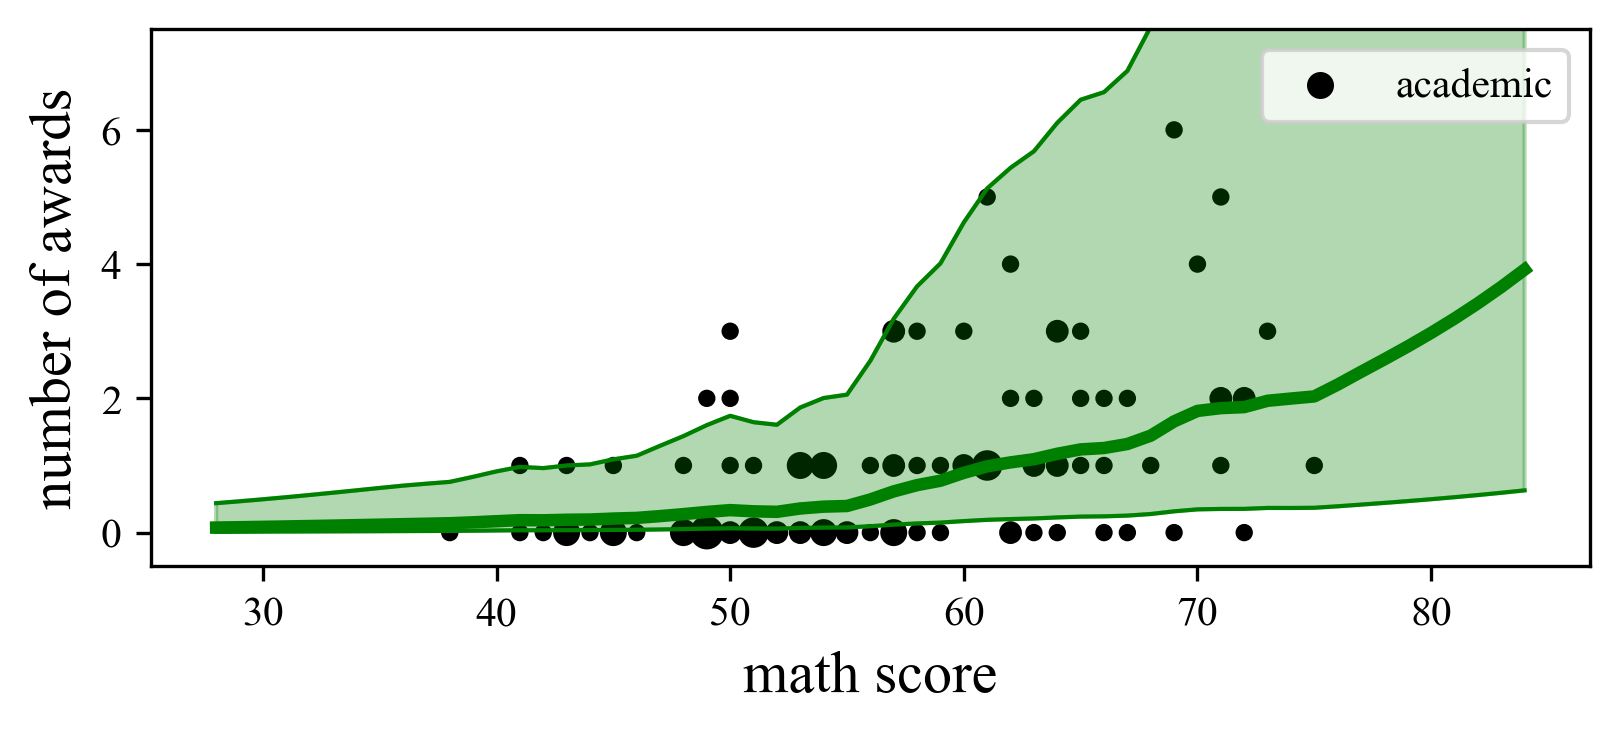

In [28]:
academic_mean = np.exp(observed_pred.mean.numpy())
lb_academic, ub_academic = observed_pred.confidence_region()
lb_academic, ub_academic = np.exp(lb_academic), np.exp(ub_academic)

fig = plt.figure(figsize=(figwidth, 1.5*figheight), dpi=300)

plt.ylim(-0.5, 7.5)
plt.ylabel('number of awards', size=14)
plt.xlabel('math score', size=14)
plt.scatter(poisson_academic_scatter_df['math'], poisson_academic_scatter_df['num_awards'],
            s=10* poisson_academic_scatter_df['count'], color='black', label='academic')
plt.plot(x_academic, academic_mean, lw=3, color='green')
plt.plot(x_academic, ub_academic, lw=1, color='green')
plt.plot(x_academic, lb_academic, lw=1, color='green')
plt.fill_between(x_academic, lb_academic, ub_academic, alpha=0.3, color='green')
plt.legend()

plt.tight_layout()

plt.savefig('figures/academic_GP.pdf')

plt.plot();

## Redo the same for vocational

In [29]:
poisson_vocational_scatter_df = poisson_vocational_df.groupby(['math', 'num_awards']).size().reset_index(name="count")
poisson_vocational_scatter_df.head(5)

,math,num_awards,count
0,33,0,1
1,37,0,1
2,38,0,1
3,39,0,3
4,39,1,1


In [30]:
X_vocational = torch.tensor(poisson_vocational_combined_df['math'])
Y_vocational = torch.tensor(poisson_vocational_combined_df['mu']).float()

x_vocational = torch.tensor(np.array(range(X_vocational.min() - 10, X_vocational.max() + 10)))

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_covar=torch.tensor(np.sqrt(poisson_vocational_combined_df['sigma2'].values)))
model = ExactGPModel(X_vocational.view(-1,1), Y_vocational, likelihood)

# this is for running the notebook in our testing framework
training_iter = 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_vocational.view(-1,1).long())
    # Calc loss and backprop gradients
    loss = -mll(output, Y_vocational)
    loss.backward()
    #print(model.covar_module.base_kernel.kernels[0])
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.kernels[0].lengthscale.item(),
            model.likelihood.noise.item()
        ))
    optimizer.step()
    
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(x_vocational))

Iter 1/50 - Loss: 1.878   lengthscale: 0.693   noise: 0.693
Iter 6/50 - Loss: 1.809   lengthscale: 0.972   noise: 0.884
Iter 11/50 - Loss: 1.766   lengthscale: 1.286   noise: 0.801
Iter 16/50 - Loss: 1.737   lengthscale: 1.552   noise: 0.731
Iter 21/50 - Loss: 1.710   lengthscale: 1.697   noise: 0.817
Iter 26/50 - Loss: 1.686   lengthscale: 1.770   noise: 0.905
Iter 31/50 - Loss: 1.660   lengthscale: 1.807   noise: 0.897
Iter 36/50 - Loss: 1.636   lengthscale: 1.794   noise: 0.900
Iter 41/50 - Loss: 1.612   lengthscale: 1.732   noise: 0.969
Iter 46/50 - Loss: 1.594   lengthscale: 1.645   noise: 1.012


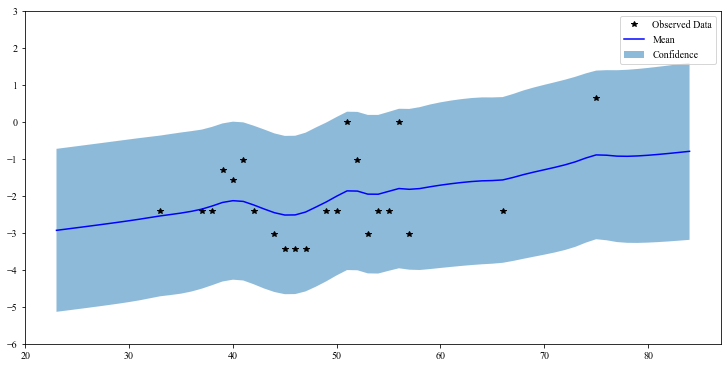

In [31]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 5))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(X_vocational.numpy(), Y_vocational.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(x_vocational.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(x_vocational.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-6, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    

<ipython-input-32-6ed0df5c860a>:18: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


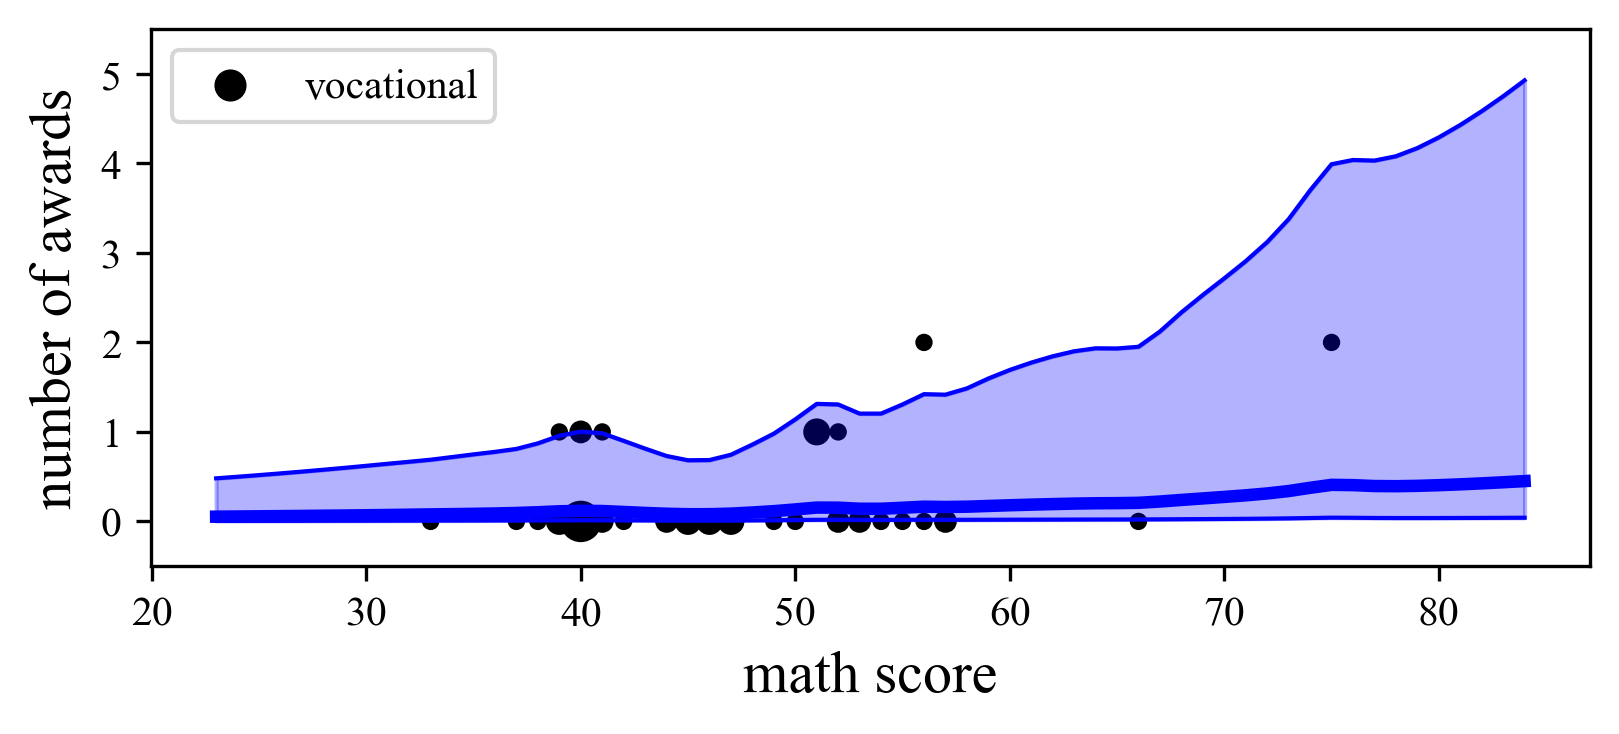

In [32]:
vocational_mean = np.exp(observed_pred.mean.numpy())
lb_vocational, ub_vocational = observed_pred.confidence_region()
lb_vocational, ub_vocational = np.exp(lb_vocational), np.exp(ub_vocational)

fig = plt.figure(figsize=(figwidth, 1.5*figheight), dpi=300)

plt.ylim(-0.5, 5.5)
plt.ylabel('number of awards', size=14)
plt.xlabel('math score', size=14)
plt.scatter(poisson_vocational_scatter_df['math'], poisson_vocational_scatter_df['num_awards'],
            s=10* poisson_vocational_scatter_df['count'], color='black', label='vocational')
plt.plot(x_vocational, vocational_mean, lw=3, color='blue')
plt.plot(x_vocational, ub_vocational, lw=1, color='blue')
plt.plot(x_vocational, lb_vocational, lw=1, color='blue')
plt.fill_between(x_vocational, lb_vocational, ub_vocational, alpha=0.3, color='blue')
plt.legend()

plt.tight_layout()
plt.savefig('figures/vocational_GP.pdf')

plt.plot();